In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import torch
from sklearn import metrics
import pickle
from tqdm import tqdm
import itertools
import gffutils
import argparse
import sqlite3
import json
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [17]:
def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]


def topdom(pred_mat, window_size=10, cutoff=0):
    if pred_mat.shape[0]-pred_mat.shape[1]:
        raise ValueError(
            'Dimension mismatch ({}, {})'.format(pred_mat.shape[0], pred_mat.shape[1])
        )
    pad_mat = np.pad(pred_mat, window_size, mode='constant', constant_values=np.nan)
    dim = pad_mat.shape[0]
    signal = np.array([
        np.nanmean(pad_mat[i-window_size:i, i:i+window_size]) for i in range(dim)
    ][window_size+1: -window_size])
    if cutoff is not None:
        signal[signal<cutoff] = cutoff

    return signal


def interpolate(signal, bin_size=10000, pattern='smooth'):
    if pattern is None: return signal
    if pattern not in ['smooth', 'zigzag']:
        raise ValueError(
            'Bad parameter, expecting \'smooth\' or \'zigzag\' but got \'{}\''.format(pattern)
        )
    if pattern=='smooth':
        l = len(signal) * bin_size
        sparse, compact = np.linspace(0, l, len(signal)), np.linspace(0, l, l)
        interp_signal = np.interp(compact, sparse, signal)
    else:
        interp_signal = np.tile(signal, (bin_size, 1)).flatten('F')
    
    return interp_signal


def sim_pearson(signal1, signal2, window_size=10):
    l = len(signal1)
    score = np.array([
        scipy.stats.pearsonr(
            signal1[i:i+window_size], signal2[i:i+window_size]
        )[0] for i in range(l-window_size)
    ])
    score[score != score] = 1

    return score


def sim_difference(signal1, signal2):
    score = signal1 - signal2
    score[score != score] = 0

    return score


def similarity(signal1, signal2, kernel='diff', window_size=10):
    if len(signal1)-len(signal2):
        raise ValueError(
            'Different signal1.length ({}) and signal2.length ({})'.format(len(signal1), len(signal2))
        )
    if kernel == 'diff':
        score = sim_difference(signal1, signal2)
    elif kernel == 'pearson':
        score = sim_pearson(signal1, signal2, window_size=window_size)
    
    return score


def threshold(score, cutoff=0.7, kernel='diff', margin=1000):
    if kernel == 'diff':
        indices = np.argwhere(np.abs(score)>=cutoff).flatten()
    elif kernel == 'pearson':
        indices = np.argwhere(score <= cutoff).flatten()
    if len(indices) == 0:
        raise ValueError(
            'No valid result above threshold. Please consider expanding your search by changing the filters'
        )
    starts, ends = [], []
    s, e = 0, 0
    for i in tqdm(indices, desc='selecting significant regions', position=0, leave=True):
        if not s and not e: s, e = i, i
        else:
            if i - e <= margin: e = i
            else:
                starts.append(s)
                ends.append(e)
                s, e = i, i
    if e != ends[-1]:
        starts.append(s)
        ends.append(e)
    regions = pd.DataFrame({
        'start': np.array(starts) - margin,
        'end': np.array(ends) + margin
    })
    return regions

In [18]:
%%time

pred_dir = '/data/leslie/suny4/predictions/chromafold/'
ct1, ct2 = 'mycGCB_am_gfp_myc_gcb_thelp_sample', 'mycGCB_am_gfp_myc_gcb_nothelp_sample'
chrom = 1
pred1, pred2 = load_pred(pred_dir, ct1, chrom, avg_stripe=True), load_pred(pred_dir, ct2, chrom, avg_stripe=True)

CPU times: user 10.9 s, sys: 6.89 s, total: 17.8 s
Wall time: 17.9 s


In [31]:
score_path = '/data/leslie/suny4/predictions/tads/mycGCB_am_gfp_myc_gcb_thelp_sample/score_mycGCB_am_gfp_myc_gcb_thelp_sample_chr1.csv'
chrscore = pd.read_csv(score_path, header=0, index_col=False)
chrscore = chrscore.head(chrscore.shape[0]-1)

In [33]:
chrscore

,id,chr,from.coord,to.coord,local.ext,mean.cf,pvalue
0,1,chr1,2000000,2010000,0,-1.041524,0.329829
1,2,chr1,2010000,2020000,0,-1.047215,0.354746
2,3,chr1,2020000,2030000,0,-1.051625,0.332100
3,4,chr1,2030000,2040000,0,-1.055497,0.200404
4,5,chr1,2040000,2050000,0,-1.057467,0.085863
...,...,...,...,...,...,...,...
19041,19042,chr1,192410000,192420000,0,-0.825660,0.999262
19042,19043,chr1,192420000,192430000,0,-0.835811,0.778545
19043,19044,chr1,192430000,192440000,0,-0.838540,0.635971
19044,19045,chr1,192440000,192450000,0,-0.806184,0.998710


In [38]:
np.testing.assert_allclose(chrscore['mean.cf'], topdom(pred1, cutoff=None))

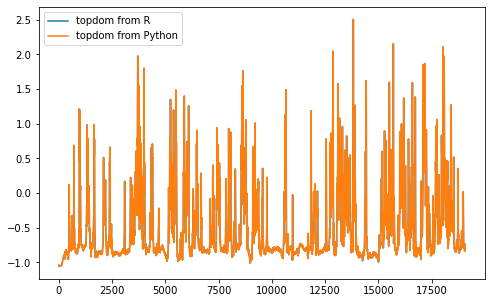

In [36]:
plt.figure(figsize=(8,5))
plt.plot(chrscore['mean.cf'], label='topdom from R')
plt.plot(topdom(pred1, cutoff=None), label='topdom from Python')
plt.legend()
plt.show()

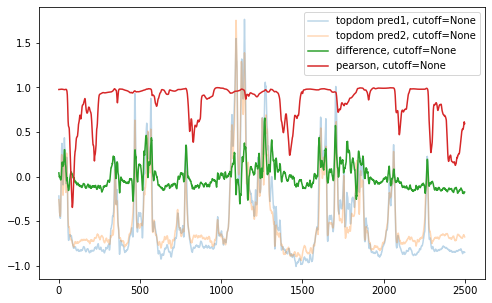

CPU times: user 3.43 s, sys: 1.25 s, total: 4.68 s
Wall time: 4.68 s


In [21]:
%%time

td1_nocutoff, td2_nocutoff = topdom(pred1, cutoff=None), topdom(pred2, cutoff=None)
diff_nocutoff = similarity(td1_nocutoff, td2_nocutoff, kernel='diff')
prs_nocutoff = similarity(td1_nocutoff, td2_nocutoff, kernel='pearson', window_size=100)
plt.figure(figsize=(8,5))
plt.plot(td1_nocutoff[7500:10000], alpha=0.3, label='topdom pred1, cutoff=None')
plt.plot(td2_nocutoff[7500:10000], alpha=0.3, label='topdom pred2, cutoff=None')
plt.plot(diff_nocutoff[7500:10000], label='difference, cutoff=None')
plt.plot(prs_nocutoff[7500:10000], label='pearson, cutoff=None, window_size=100')
plt.legend()
plt.show()

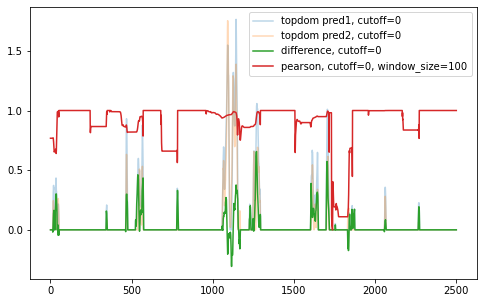

CPU times: user 2.85 s, sys: 1.27 s, total: 4.12 s
Wall time: 4.12 s


In [22]:
%%time

td1_cutoff, td2_cutoff = topdom(pred1, cutoff=0), topdom(pred2, cutoff=0)
diff_cutoff = similarity(td1_cutoff, td2_cutoff, kernel='diff')
prs_cutoff = similarity(td1_cutoff, td2_cutoff, kernel='pearson', window_size=100)
plt.figure(figsize=(8,5))
plt.plot(td1_cutoff[7500:10000], alpha=0.3, label='topdom pred1, cutoff=0')
plt.plot(td2_cutoff[7500:10000], alpha=0.3, label='topdom pred2, cutoff=0')
plt.plot(diff_cutoff[7500:10000], label='difference, cutoff=0')
plt.plot(prs_cutoff[7500:10000], label='pearson, cutoff=0, window_size=100')
plt.legend()
plt.show()

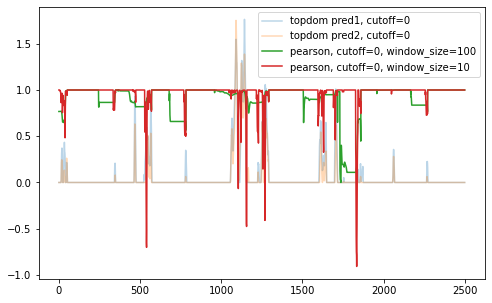

CPU times: user 564 ms, sys: 42 ms, total: 606 ms
Wall time: 580 ms


In [24]:
%%time

prs10_cutoff = similarity(td1_cutoff, td2_cutoff, kernel='pearson', window_size=10)
plt.figure(figsize=(8,5))
plt.plot(td1_cutoff[7500:10000], alpha=0.3, label='topdom pred1, cutoff=0')
plt.plot(td2_cutoff[7500:10000], alpha=0.3, label='topdom pred2, cutoff=0')
plt.plot(prs_cutoff[7500:10000], label='pearson, cutoff=0, window_size=100')
plt.plot(prs10_cutoff[7500:10000], label='pearson, cutoff=0, window_size=10')
plt.legend()
plt.show()

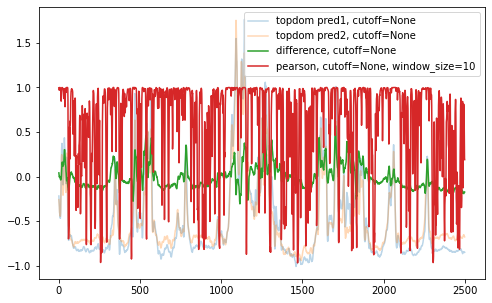

CPU times: user 1.59 s, sys: 162 ms, total: 1.75 s
Wall time: 1.6 s


In [27]:
%%time

prs10_nocutoff = similarity(td1_nocutoff, td2_nocutoff, kernel='pearson', window_size=10)
plt.figure(figsize=(8,5))
plt.plot(td1_nocutoff[7500:10000], alpha=0.3, label='topdom pred1, cutoff=None')
plt.plot(td2_nocutoff[7500:10000], alpha=0.3, label='topdom pred2, cutoff=None')
plt.plot(diff_nocutoff[7500:10000], label='difference, cutoff=None')
plt.plot(prs10_nocutoff[7500:10000], label='pearson, cutoff=None, window_size=10')
plt.legend()
plt.show()

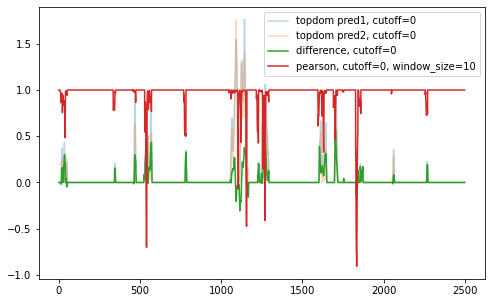

CPU times: user 199 ms, sys: 9.15 ms, total: 208 ms
Wall time: 206 ms


In [26]:
%%time

plt.figure(figsize=(8,5))
plt.plot(td1_cutoff[7500:10000], alpha=0.3, label='topdom pred1, cutoff=0')
plt.plot(td2_cutoff[7500:10000], alpha=0.3, label='topdom pred2, cutoff=0')
plt.plot(diff_cutoff[7500:10000], label='difference, cutoff=0')
plt.plot(prs10_cutoff[7500:10000], label='pearson, cutoff=0, window_size=10')
plt.legend()
plt.show()

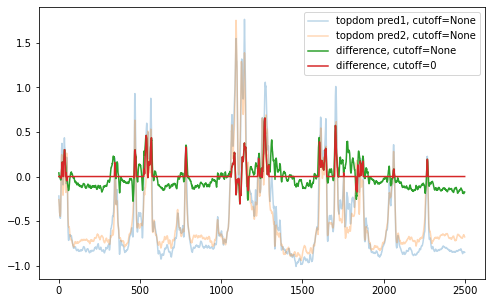

CPU times: user 201 ms, sys: 12.8 ms, total: 214 ms
Wall time: 212 ms


In [30]:
%%time

plt.figure(figsize=(8,5))
plt.plot(td1_nocutoff[7500:10000], alpha=0.3, label='topdom pred1, cutoff=None')
plt.plot(td2_nocutoff[7500:10000], alpha=0.3, label='topdom pred2, cutoff=None')
plt.plot(diff_nocutoff[7500:10000], label='difference, cutoff=None')
plt.plot(diff_cutoff[7500:10000], label='difference, cutoff=0')
plt.legend()
plt.show()